In [20]:
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
tb = pd.read_csv('../data/team_batting_2018-05-12.csv')
tp = pd.read_csv('../data/team_pitching_2018-05-12.csv')
pp = pd.read_csv('../data/player_pitching_2018-05-12.csv')

In [48]:
# Extract Doubleheader information from date, and make its own feature
tb['Game#'] = tb['Date'].apply(lambda x: int(x[-2]) if x[-1]==')' else 1)
tp['Game#'] = tb['Date'].apply(lambda x: int(x[-2]) if x[-1]==')' else 1)
pp['Game#'] = tb['Date'].apply(lambda x: int(x[-2]) if x[-1]==')' else 1)

In [52]:
# Remove Doubleheader information from date
tb['Date'] = tb['Date'].apply(lambda x: x[:10])
tp['Date'] = tp['Date'].apply(lambda x: x[:10])
pp['Date'] = pp['Date'].apply(lambda x: x[:10])

In [54]:
# Make Date a datetime type
tb['Date'] = pd.to_datetime(tb['Date'])
tp['Date'] = pd.to_datetime(tp['Date'])
pp['Date'] = pd.to_datetime(pp['Date'])

In [59]:
# Extract Win/Loss information from 'Rslt', and make its own feature
tb['Win/Loss'] = tb['Rslt'].apply(lambda x: 1 if x[0]=='W' else 0)

In [77]:
# Filter pp for just starting pitchers
pps = pp[pp['AppDec'].apply(lambda x: True if x[:2]=='GS' else False)]

In [78]:
pps['#innings'] = pps['AppDec'].apply(lambda x: int(x[3]))

In [ ]:
tb_window = ['PA', 'R', 'H', '2B', '3B', 'HR', 'RBI', # batting strength
             'SO', 'GDP', 'LOB', # batting weakness
             'SB', # running strength
             'CS', # running weakness
             'Win/Loss', # overall team winningness
             'WPA', 'RE24', 'aLI' # BR Measures
            ]

tp_window = ['H', 'R', '2B', '3B', 'ER', 'SO', 'HR', 'Str', 'GDP', # pitching strength
             'Pit', 'BF', 'WP',
             'WPA', 'RE24', 'aLI'
            ]

pps_window

In [79]:
pps.dtypes

Rk                   int64
Player              object
Date        datetime64[ns]
Tm                  object
Opp                 object
Rslt                object
AppDec              object
IP                 float64
H                    int64
R                    int64
ER                   int64
BB                   int64
SO                   int64
HR                   int64
UER                  int64
Pit                float64
Str                float64
GSc                float64
IR                 float64
IS                 float64
BF                   int64
AB                   int64
2B                   int64
3B                   int64
IBB                  int64
HBP                  int64
SH                   int64
SF                   int64
GDP                  int64
SB                   int64
CS                   int64
PO                   int64
BK                   int64
WP                   int64
ERA                 object
WPA                float64
RE24               float64
a

In [25]:
tb.head()

,Rk,Date,Tm,Opp,Rslt,PA,AB,R,H,2B,...,GDP,SB,CS,WPA,RE24,aLI,LOB,#,Attendance,GmLen
0,1,2018-05-12,LAA,MIN,L 3-5,55,41,3,7,1,...,1,1,0,-0.620,-3.080,2.006,16,11,40117.0,261
1,2,2018-05-12,ARI,WSN,L 1-2,36,32,1,5,1,...,0,0,0,-0.780,-4.123,1.771,8,16,29428.0,197
2,3,2018-05-12,ATL,MIA,W 10-5,43,37,10,12,0,...,1,1,0,0.618,5.682,1.141,6,17,12383.0,206
3,4,2018-05-12,BOS,TOR,W 5-2,39,38,5,12,4,...,0,0,1,0.090,0.007,0.667,7,9,37588.0,191
4,5,2018-05-12,CHC,CHW,W 8-4,41,33,8,9,0,...,0,2,0,0.299,3.784,0.328,9,15,41099.0,200


## tb: Team Batting
- PA: Plate Appearances
- AB: At Bats
- R: Runs
- H: Hits
- BB: Bases on Balls
- IBB: Intentional Bases on Balls 
- SO: Strikeouts
- HBP: Hit-by-pitch
- SH: Sacrifice Hits
- SF: Sacrifice Flies
- ROE: Reached on Error
- GDB: Double Plays Grounded Into
- SB: Stolen Bases
- CS: Caught Stealing
- WPA: Win Probability Added for Offensive Player (BR measure)
- RE24: Base-out Runs Added (BR measure)
- aLI: Average Leverage Index (BR measure)
- LOB: Runners Left on Base
- #: Number of Players Used in Game
- GmLen: Game Length (minutes)

In [29]:
tp.head()

,Rk,Date,Tm,Opp,Rslt,IP,H,R,ER,BB,...,PO,BK,WP,ERA,WPA,RE24,aLI,#,Attendance,GmLen
0,1,2018-05-12,LAA,MIN,L 3-5,12.0,10,5,5,4,...,0,0,0,3.75,0.123,1.081,1.282,5,40117.0,261
1,2,2018-05-12,ARI,WSN,L 1-2,9.0,7,2,2,7,...,1,0,0,2.00,0.279,3.123,1.227,5,29428.0,197
2,3,2018-05-12,ATL,MIA,W 10-5,9.0,10,5,1,2,...,0,0,0,1.00,-0.118,-0.682,1.271,6,12383.0,206
3,4,2018-05-12,BOS,TOR,W 5-2,9.0,7,2,2,3,...,0,0,0,2.00,0.411,2.994,1.170,5,37588.0,191
4,5,2018-05-12,CHC,CHW,W 8-4,9.0,8,4,4,4,...,0,0,0,4.00,0.201,0.743,0.570,5,41099.0,200


## tp: Team Pitching
- ER: Earned Runs Allowed
- UER: Unearned Runs Allowed
- Pit: Number of total pitches
- Str: Number of total strikes
- IR: Number of inherited runners
- IS: Inherited Score
- BF: Batters Faced
- SB: Stolen Bases
- CS: Caught Stealing
- PO: Pickoffs
- BK: Balks
- ERA: Earned Run Average
- WPA: Win Probability added by Pitcher (BR measure)
- RE24: Base-Out Runs Saved (BR measure)
- #: Number of pitchers used in the game

In [33]:
pp.head()

,Rk,Player,Date,Tm,Opp,Rslt,AppDec,IP,H,R,...,CS,PO,BK,WP,ERA,WPA,RE24,aLI,DFS(DK),DFS(FD)
0,1,Matt Albers\alberma01,2018-05-12,MIL,COL,L 0-4,8-GF(8),1.0,0,0,...,0,0,0,0,0.00,0.004,0.595,0.050,4.25,6.0
1,2,Cody Allen\allenco01,2018-05-12,CLE,KCR,W 6-2,9-GF,1.0,0,0,...,0,0,0,0,0.00,0.017,0.560,0.213,6.25,9.0
2,3,Alec Asher\asheral01,2018-05-12,MIL,COL,L 0-4,6-7,2.0,2,0,...,0,0,0,0,0.00,0.023,1.189,0.212,6.70,12.0
3,4,Pedro Baez\baezpe01,2018-05-12,LAD,CIN,L 3-5,9-GF,1.0,2,0,...,0,0,0,0,0.00,0.017,0.501,0.418,3.05,6.0
4,5,Homer Bailey\baileho02,2018-05-12,CIN,LAD,W 5-3,GS-5 W,5.0,10,3,...,0,0,0,1,5.40,-0.111,-0.495,1.203,10.05,30.0


## pp: Player Pitching
- AppDec: Indicates starting and ending of pitcher
- GSc: Game Score (BR Measure)
- WP: Wild Pitches

In [23]:
df.groupby('Date').mean()['GmLen']

Date
2018-03-29        195.230769
2018-03-30        209.818182
2018-03-31        186.785714
2018-04-01        178.400000
2018-04-01 (1)    150.000000
2018-04-01 (2)    194.000000
2018-04-02        195.250000
2018-04-03        186.692308
2018-04-04        177.916667
2018-04-05        194.636364
2018-04-06        210.000000
2018-04-07        198.400000
2018-04-08        186.000000
2018-04-09        184.666667
2018-04-10        184.733333
2018-04-11        193.600000
2018-04-12        179.125000
2018-04-13        186.785714
2018-04-14        183.083333
2018-04-15        185.700000
2018-04-16        173.888889
2018-04-17        184.714286
2018-04-17 (1)    176.000000
2018-04-17 (2)    217.000000
2018-04-18        205.076923
2018-04-19        183.666667
2018-04-20        191.357143
2018-04-20 (1)    166.000000
2018-04-20 (2)    154.000000
2018-04-21        174.866667
2018-04-22        188.357143
2018-04-23        183.555556
2018-04-24        189.846154
2018-04-25        184.714286
2018-04-2

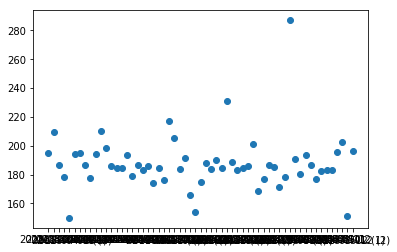

In [22]:
plt.scatter(df.groupby('Date').mean()['GmLen'].index, df.groupby('Date').mean()['GmLen'])

In [10]:
df['Rslt']

0        L 3-5
1        L 1-2
2       W 10-5
3        W 5-2
4        W 8-4
5        L 4-8
6        W 5-3
7        W 6-2
8        W 4-0
9       L 5-10
10       W 6-1
11       L 2-6
12       L 3-5
13       L 0-4
14       W 5-3
15       W 7-6
16       L 6-7
17       W 6-5
18       W 2-1
19       L 5-6
20       L 1-2
21       L 1-6
22       L 2-5
23       W 2-1
24       W 6-3
25       W 4-3
26       L 3-4
27       L 3-6
28      L 3-10
29       L 5-9
         ...  
1132     L 0-1
1133     W 5-1
1134     L 2-4
1135     W 2-0
1136     L 5-6
1137     W 8-2
1138     W 8-5
1139     W 3-2
1140     L 4-6
1141     W 8-4
1142    W 14-7
1143     L 1-2
1144     L 2-8
1145     L 4-8
1146     W 4-1
1147    L 7-14
1148     L 0-1
1149     W 2-1
1150     L 2-3
1151     W 9-4
1152     W 6-1
1153     W 6-5
1154     L 5-8
1155     L 1-2
1156     W 2-1
1157     W 1-0
1158     L 4-9
1159     W 6-4
1160     L 1-4
1161     L 1-6
Name: Rslt, Length: 1162, dtype: object

In [9]:
df['Rslt'].apply(lambda x: 'W' if x[0] == 'W' else 'L')

0       L
1       L
2       W
3       W
4       W
5       L
6       W
7       W
8       W
9       L
10      W
11      L
12      L
13      L
14      W
15      W
16      L
17      W
18      W
19      L
20      L
21      L
22      L
23      W
24      W
25      W
26      L
27      L
28      L
29      L
       ..
1132    L
1133    W
1134    L
1135    W
1136    L
1137    W
1138    W
1139    W
1140    L
1141    W
1142    W
1143    L
1144    L
1145    L
1146    W
1147    L
1148    L
1149    W
1150    L
1151    W
1152    W
1153    W
1154    L
1155    L
1156    W
1157    W
1158    L
1159    W
1160    L
1161    L
Name: Rslt, Length: 1162, dtype: object

In [6]:
df.dtypes

Rk              int64
Date           object
Tm             object
Opp            object
Rslt           object
PA              int64
AB              int64
R               int64
H               int64
2B              int64
3B              int64
HR              int64
RBI             int64
BB              int64
IBB             int64
SO              int64
HBP             int64
SH              int64
SF              int64
ROE             int64
GDP             int64
SB              int64
CS              int64
WPA           float64
RE24          float64
aLI           float64
LOB             int64
#               int64
Attendance    float64
GmLen           int64
dtype: object

In [7]:
df['Date']

0           2018-05-12
1           2018-05-12
2           2018-05-12
3           2018-05-12
4           2018-05-12
5           2018-05-12
6           2018-05-12
7           2018-05-12
8           2018-05-12
9           2018-05-12
10          2018-05-12
11          2018-05-12
12          2018-05-12
13          2018-05-12
14          2018-05-12
15          2018-05-12
16          2018-05-12
17          2018-05-12
18          2018-05-12
19          2018-05-12
20          2018-05-12
21          2018-05-12
22          2018-05-12
23          2018-05-12
24      2018-05-12 (1)
25      2018-05-12 (1)
26      2018-05-12 (1)
27      2018-05-12 (1)
28      2018-05-12 (2)
29      2018-05-12 (2)
             ...      
1132        2018-03-30
1133        2018-03-30
1134        2018-03-30
1135        2018-03-30
1136        2018-03-29
1137        2018-03-29
1138        2018-03-29
1139        2018-03-29
1140        2018-03-29
1141        2018-03-29
1142        2018-03-29
1143        2018-03-29
1144       

In [8]:
df['Rslt']

0        L 3-5
1        L 1-2
2       W 10-5
3        W 5-2
4        W 8-4
5        L 4-8
6        W 5-3
7        W 6-2
8        W 4-0
9       L 5-10
10       W 6-1
11       L 2-6
12       L 3-5
13       L 0-4
14       W 5-3
15       W 7-6
16       L 6-7
17       W 6-5
18       W 2-1
19       L 5-6
20       L 1-2
21       L 1-6
22       L 2-5
23       W 2-1
24       W 6-3
25       W 4-3
26       L 3-4
27       L 3-6
28      L 3-10
29       L 5-9
         ...  
1132     L 0-1
1133     W 5-1
1134     L 2-4
1135     W 2-0
1136     L 5-6
1137     W 8-2
1138     W 8-5
1139     W 3-2
1140     L 4-6
1141     W 8-4
1142    W 14-7
1143     L 1-2
1144     L 2-8
1145     L 4-8
1146     W 4-1
1147    L 7-14
1148     L 0-1
1149     W 2-1
1150     L 2-3
1151     W 9-4
1152     W 6-1
1153     W 6-5
1154     L 5-8
1155     L 1-2
1156     W 2-1
1157     W 1-0
1158     L 4-9
1159     W 6-4
1160     L 1-4
1161     L 1-6
Name: Rslt, Length: 1162, dtype: object